# data loading and analysis

In [15]:
# 1. Mount your Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# 2. Imports
import pandas as pd
import numpy as np

# 3. Your column names and mapping
columns = ["target", "id", "date", "flag", "user", "text"]
mapping = {0: "negative", 4: "positive"}

# 4. Path to your file in Drive — update to match your folder structure
data_path = '/content/drive/MyDrive/AI/1_600_000tweets.csv'

# 5. Read it in
df = pd.read_csv(
    data_path,
    encoding="ISO-8859-1",
    low_memory=False,
    names=columns
)

# 6. Inspect
print("DataFrame first 5 rows:")
print(df.head(5), "\n")

print("DataFrame columns:")
for col in df.columns:
    print(col)
print()

print("DataFrame shape:")
print(df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame first 5 rows:
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....   

DataFrame columns:
tar

about the data, target is the sentiment (0 = negative, 4 = positive), text is the tweet. These are the most important parts of the dataset. Lets plot the sentiment.

distribution of values is 50/50


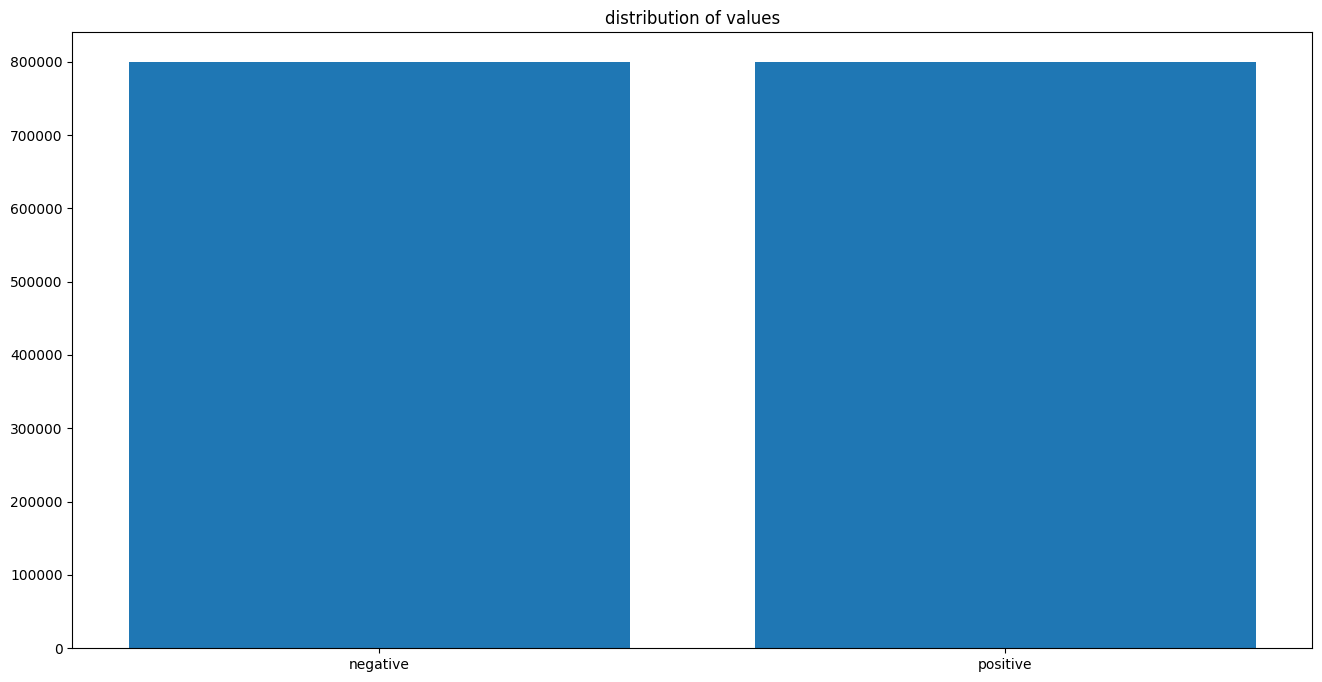

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

targets = Counter(df.target)

# replace target values with their labels
for k, v in mapping.items():
    targets[v] = targets.pop(k)

plt.figure(figsize=(16, 8))
plt.bar(targets.keys(), targets.values())
plt.title("distribution of values")

print("distribution of values is 50/50")
plt.show()

# Data preprocessing

lets remove thinks like links, irregular characters, and twitter mentions, that do not contrbiute to the sentiment

In [17]:
import re

def preprocess(text):
    # remove links
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # remove user mentions
    text = re.sub(r"@\w+", "", text)
    # remove hashtags
    text = re.sub(r"#\w+", "", text)
    # remove special characters
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# apply the preprocessing function to the text column
df["text"] = df["text"].apply(preprocess)

Drop stop words too. stop words are words that add no context to the sentiment, such as the noun. a stemmer breaks words into smaller subwords, for example adjustable -> adjust.

In [18]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")

def preprocess_text(text):
  tokens = []
  for token in text.split():
    if token not in stop_words:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

# apply the preprocessing function to the text column
df["text"] = df["text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


All we really care about is the sentiment and text honestly. Reduce data size by transforming to this.

In [19]:
# drop the unnecessary columns if they exist
if "id" in df.columns and "date" in df.columns and "flag" in df.columns and "user" in df.columns:
    df = df.drop(columns=["id", "date", "flag", "user"])

print(df.head(5))

   target                                               text
0       0  a that bummer you shoulda got david carr third...
1       0  upset cant updat facebook text might cri resul...
2       0  i dive mani time ball manag save 50 the rest g...
3       0                    whole bodi feel itchi like fire
4       0                            behav im mad i cant see


### TODO : Next steps : word embedding - simulate a function similar to Word2Vec, which converts the language into a useable vector format.

# Split into training and testing

In [20]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.15, random_state=42)

print("train data shape: ", train_data.shape)
print("test data shape: ", test_data.shape)

train data shape:  (1360000, 2)
test data shape:  (240000, 2)


# Tokenization

In [21]:
# Break sentences into their words
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

vocab_size = len(tokenizer.word_index) + 1
print("vocab size: ", vocab_size)

vocab size:  336497


In [22]:
# Make sure sequences arethe same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen=50)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen=50)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (1360000, 50)
x_test shape:  (240000, 50)


Word embedding - words kinda are unusable as text, turn it into a useable vector

In [23]:
import urllib.request
import zipfile
import os

# WARNING: BIG FILE
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_zip_path = 'glove.6B.zip'
glove_dir = 'glove.6B'

# Download
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(url, glove_zip_path)

# Unzip
if not os.path.exists(glove_dir):
    print("Unzipping...")
    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)

print("Done.")


Unzipping...
Done.


In [26]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load GloVe
embedding_index = {}
with open('glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build model with pretrained embeddings
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], trainable=False),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])


# Build the model ??